In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation


In [ ]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask): # mask là 1 image RGB (H, W, 3)
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32) # tạo 1 object mask (H, W, 21)
        for label_index, label in enumerate(VOC_COLORMAP):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float) # mask == label trả về matrix T/F (H, W, 3) check từng pixel theo chiều sâu channels.
                                                                                              # np.all sẽ kiểm tra nếu pixel nào có channel cùng màu với VOC_COLORMAP thì trả về True, ta dc 1 matrix True/False (H, W).
                                                                                              # astype() convert matrix [True False] về kiểu float [1. 0.]

        return segmentation_mask #0, 1, 2, 3, ..., 20 (H, W, C)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze() #torch.tensor argmax()-> (H, W, 1) -> (H, W) #numpy

In [ ]:
trainsize = 257

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


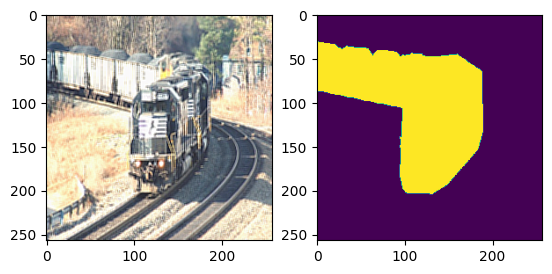

In [ ]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_trainsform)

image, mask = train_dataset.__getitem__(10)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()


In [ ]:
x = np.arange(24).reshape((2, 3, 4)) # 2 samples, mỗi sample có 3 gàn 4 cột
print(x)
res = np.argmax(x, axis=1, keepdims = True) # keepdims giữ shape output = shape input
print(res)
print(res.shape)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
[[[2 2 2 2]]

 [[2 2 2 2]]]
(2, 1, 4)


In [ ]:
!gdown 1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA

Downloading...
From: https://drive.google.com/uc?id=1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA
To: /content/resnet50_v2.pth
100% 103M/103M [00:01<00:00, 72.5MB/s] 


In [ ]:
#resnet backbone
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = conv3x3(64, 64)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = conv3x3(64, 128)
            self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
        model_path = './resnet50_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
        model_path = './resnet101_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
        model_path = './resnet152_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model

In [ ]:
import torch.nn.functional as F
#  model PSPNet

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=2, zoom_factor=8, use_ppm=True, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.use_ppm = use_ppm
        self.criterion = criterion

        if layers == 50:
            resnet = resnet50(pretrained=pretrained)
        elif layers == 101:
            resnet = resnet101(pretrained=pretrained)
        else:
            resnet = resnet152(pretrained=pretrained)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        fea_dim = 2048
        if use_ppm:
            self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
            fea_dim *= 2
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )

    def forward(self, x, y=None):
        x_size = x.size()
        assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        if self.use_ppm:
            x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x



In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 32
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = PSPNet(classes=21).to(device)

#loss
criterion = nn.CrossEntropyLoss() # CrossEntropy loss cho multiple classes

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 20

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 2


In [ ]:
for ep in range(1, 1+n_eps):
  acc_meter.reset()
  train_loss_meter.reset()
  dice_meter.reset()
  iou_meter.reset()
  model.train()

  for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
    optimizer.zero_grad()
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).long() # hàm entropy loss nhận output là indices của class trong class_list nên chuyển sang long = int64
    y_hat_mask, main_loss, aux_loss = model(x, y)
    loss = main_loss + aux_loss*0.4
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      # y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
      dice_score = dice_fn(y_hat_mask, y.long())
      iou_score = iou_fn(y_hat_mask, y.long())
      accuracy = accuracy_function(y_hat_mask, y.long())

      train_loss_meter.update(loss.item(), n)
      iou_meter.update(iou_score.item(), n)
      dice_meter.update(dice_score.item(), n)
      acc_meter.update(accuracy.item(), n)

  print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
      ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
  ))
  if ep >= 15:
      torch.save(model.state_dict(), "/content/modelPSPNet_ep_{}.pth".format(ep))

100%|██████████| 46/46 [04:38<00:00,  6.06s/it]


EP 1, train loss = 2.2562686576217903, accuracy = 0.7535324476944293, IoU = 0.22969622327818898, dice = 0.31225250856798203


100%|██████████| 46/46 [04:35<00:00,  5.98s/it]


EP 2, train loss = 1.1954014197073348, accuracy = 0.8607206979735953, IoU = 0.3625673221760109, dice = 0.4592375633169393


100%|██████████| 46/46 [04:45<00:00,  6.21s/it]


EP 3, train loss = 0.8877517766639834, accuracy = 0.8809974200087167, IoU = 0.4219221319657206, dice = 0.5197143066124837


100%|██████████| 46/46 [04:41<00:00,  6.12s/it]


EP 4, train loss = 0.7196219384344549, accuracy = 0.8967596149184013, IoU = 0.4602978788112682, dice = 0.5565282673132225


100%|██████████| 46/46 [04:40<00:00,  6.11s/it]


EP 5, train loss = 0.6178860309345474, accuracy = 0.9057238499323527, IoU = 0.504759810987066, dice = 0.601518310484339


100%|██████████| 46/46 [04:42<00:00,  6.15s/it]


EP 6, train loss = 0.5380706337631725, accuracy = 0.9154344142460432, IoU = 0.5261489449303007, dice = 0.6174101744844613


100%|██████████| 46/46 [04:42<00:00,  6.15s/it]


EP 7, train loss = 0.48119965521364266, accuracy = 0.9230771351381729, IoU = 0.5660976018410563, dice = 0.6603824251987895


100%|██████████| 46/46 [04:41<00:00,  6.13s/it]


EP 8, train loss = 0.4387282449039605, accuracy = 0.9267491851348043, IoU = 0.5912156243467591, dice = 0.6823685192019562


100%|██████████| 46/46 [04:45<00:00,  6.20s/it]


EP 9, train loss = 0.40279976331471096, accuracy = 0.9317238539294467, IoU = 0.6056956349174833, dice = 0.6961148619000378


100%|██████████| 46/46 [04:43<00:00,  6.17s/it]


EP 10, train loss = 0.3678598537471125, accuracy = 0.9375295049505807, IoU = 0.6339747150087617, dice = 0.7233536881827266


100%|██████████| 46/46 [04:41<00:00,  6.12s/it]


EP 11, train loss = 0.34060227414949346, accuracy = 0.9411207089007226, IoU = 0.6457784911973881, dice = 0.7324097469204762


100%|██████████| 46/46 [04:39<00:00,  6.08s/it]


EP 12, train loss = 0.3255354859789864, accuracy = 0.9417881177422779, IoU = 0.6350402929743783, dice = 0.7197310185171867


100%|██████████| 46/46 [04:40<00:00,  6.10s/it]


EP 13, train loss = 0.31285583321514027, accuracy = 0.9437845316740985, IoU = 0.6519595726591642, dice = 0.7359118096815432


100%|██████████| 46/46 [04:41<00:00,  6.12s/it]


EP 14, train loss = 0.2956616370404353, accuracy = 0.9455218751573823, IoU = 0.6600407384783844, dice = 0.7435016143517416


100%|██████████| 46/46 [04:42<00:00,  6.14s/it]


EP 15, train loss = 0.2784655173945297, accuracy = 0.9480115543297731, IoU = 0.6800675317237938, dice = 0.7621506771754697


100%|██████████| 46/46 [04:39<00:00,  6.08s/it]


EP 16, train loss = 0.27382137760764264, accuracy = 0.9469747836472558, IoU = 0.6776786931876928, dice = 0.7601199544192664


100%|██████████| 46/46 [04:39<00:00,  6.07s/it]


EP 17, train loss = 0.26697103215045614, accuracy = 0.9481731340533397, IoU = 0.6773878918970869, dice = 0.7582265640217098


100%|██████████| 46/46 [04:38<00:00,  6.04s/it]


EP 18, train loss = 0.25994127255971317, accuracy = 0.9493621851577133, IoU = 0.6868911610275018, dice = 0.7696443229425148


100%|██████████| 46/46 [04:35<00:00,  5.98s/it]


EP 19, train loss = 0.2377693171058196, accuracy = 0.9531183255826189, IoU = 0.7054673570101379, dice = 0.7855686310861931


100%|██████████| 46/46 [04:36<00:00,  6.01s/it]


EP 20, train loss = 0.22653251552516646, accuracy = 0.9545850274992771, IoU = 0.7204537574059325, dice = 0.7990525322533696
